# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [12]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.cm as cm
# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [13]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
5,6,March,Prosecco,144,86,Chile,False
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
8,9,April,Chardonnay,144,57,Chile,False
9,10,April,Prosecco,72,52,California,False


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [14]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1
5,Williams,18,1
6,Williams,22,1
7,Williams,31,1
8,Brown,7,1
9,Brown,29,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [15]:
#your turn
df_merged= pd.merge(df_transactions,df_offers)
forCluster= pd.pivot_table(df_merged, index= ['customer_name'], columns=['offer_id'], values= 'n', fill_value=0)


df_merged

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,1,January,Pinot Noir,72,17,France,False
2,Martin,2,1,January,Pinot Noir,72,17,France,False
3,Jackson,2,1,January,Pinot Noir,72,17,France,False
4,Campbell,2,1,January,Pinot Noir,72,17,France,False
5,Mitchell,2,1,January,Pinot Noir,72,17,France,False
6,Peterson,2,1,January,Pinot Noir,72,17,France,False
7,Bell,2,1,January,Pinot Noir,72,17,France,False
8,Cox,2,1,January,Pinot Noir,72,17,France,False
9,Fisher,2,1,January,Pinot Noir,72,17,France,False


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

We want the lowest values of SS without over clustering. Lower values means our clusters are tighter. Cluster can be too tight though so it is import to find the 'elbow' point.

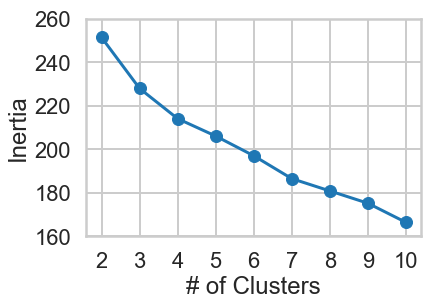

[251.46031746031744, 227.98503490702979, 214.1080827067669, 206.102849002849, 197.04221073044604, 186.52183705183703, 180.86954099821747, 175.20930735930736, 166.41336996336997]


In [16]:
# your turn
from sklearn.cluster import KMeans
x_cols= forCluster.values
ss=[]

ks=range(2,11)
for k in ks:

    kmeans=KMeans(n_clusters=k).fit(x_cols)
    
    ss.append(kmeans.inertia_)
plt.plot(ks, ss, '-o')
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.yticks([160, 180, 200, 220, 240, 260])
plt.show()
print(ss)

Text(0,0.5,'# of points')

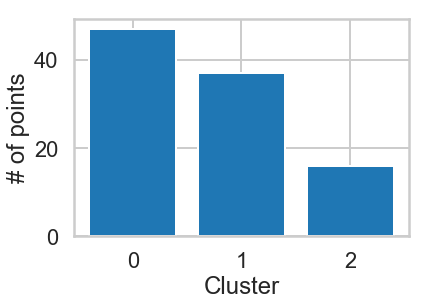

In [17]:
kmeans=KMeans(n_clusters=3).fit_predict(x_cols)
vis= pd.Series(kmeans).value_counts()

plt.bar(vis.index, vis.values)
plt.xlabel('Cluster')
plt.ylabel('# of points')


The main difficulty I expierineced was the lack of an obvious 'elbow' point. I chose three because the difference between two and three is clearly larger than between three and four. Not by a lot though. It seemd more clusters may be necessary but it seemed hypocritical to choose four five clusters when those differences were so similar to the one between three and four clusters.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [18]:
# Your turn.
#First we need to reduce the dimensionality of the data
from sklearn.decomposition import PCA
pca= PCA(n_components=2)
redu=pca.fit_transform(x_cols)
x=redu[:,0]
y=redu[:,1]


The silhouette score for 2 clusters is: 0.412206549061
The silhouette score for 3 clusters is: 0.530346804798
The silhouette score for 4 clusters is: 0.44784247587
The silhouette score for 5 clusters is: 0.470122949088
The silhouette score for 6 clusters is: 0.471031766017
The silhouette score for 7 clusters is: 0.498313376466
The silhouette score for 8 clusters is: 0.514199507178
The silhouette score for 9 clusters is: 0.513326467098
The silhouette score for 10 clusters is: 0.513880034772


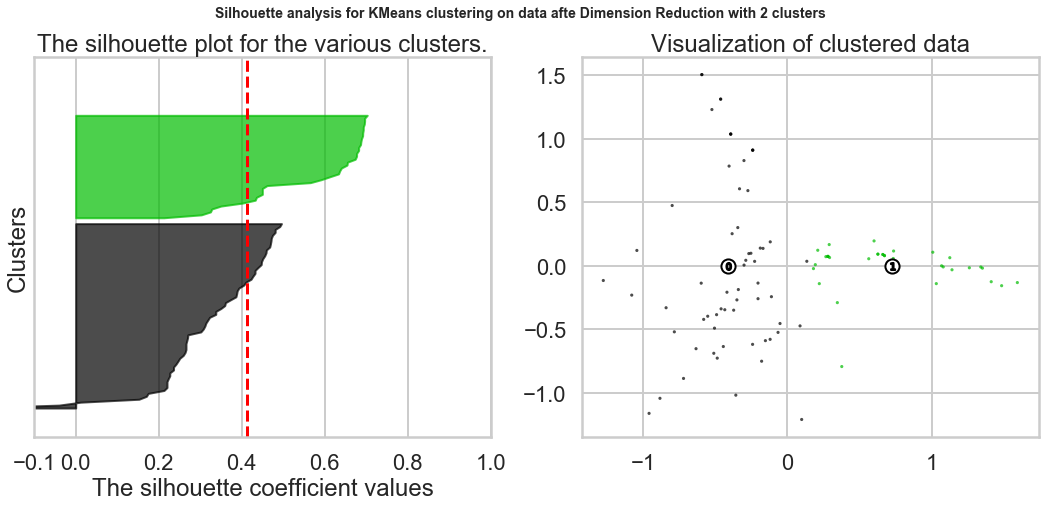

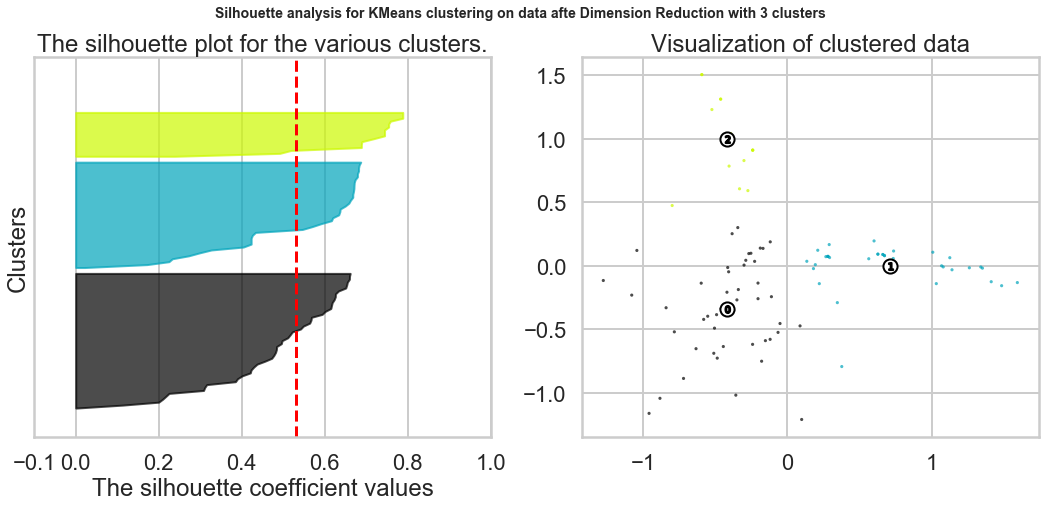

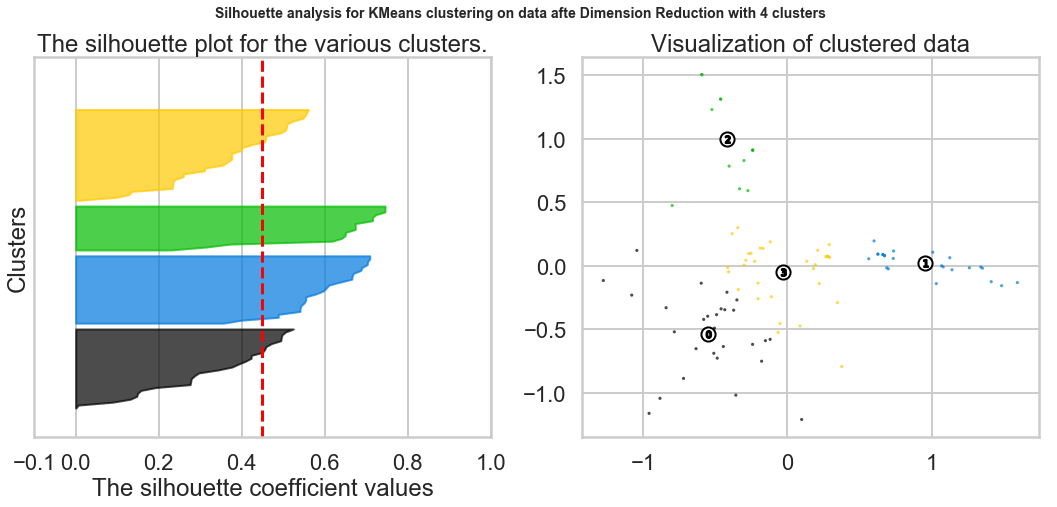

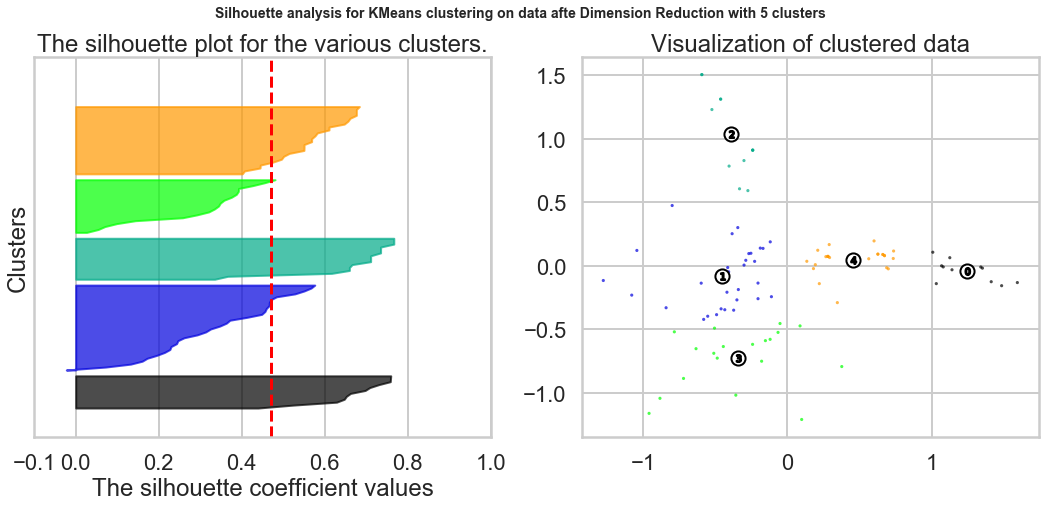

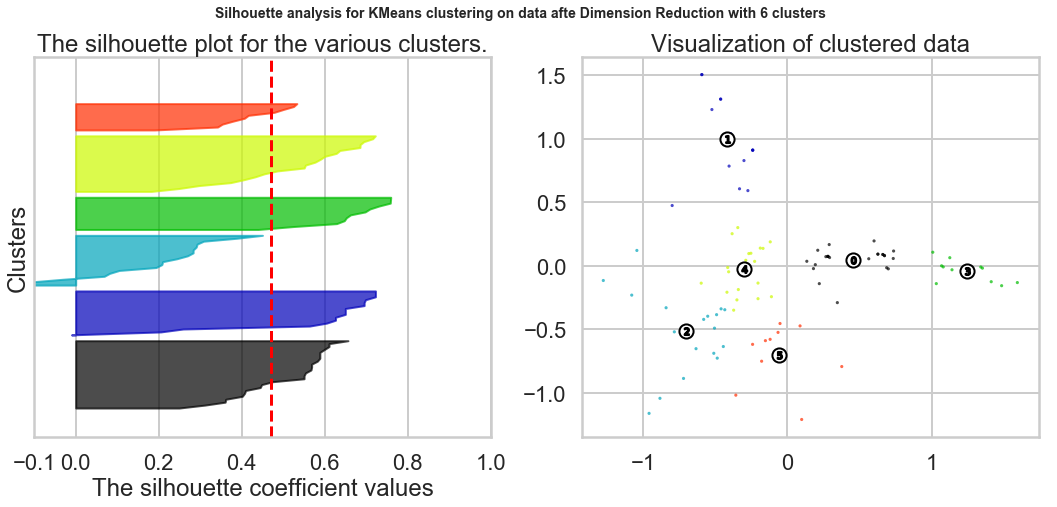

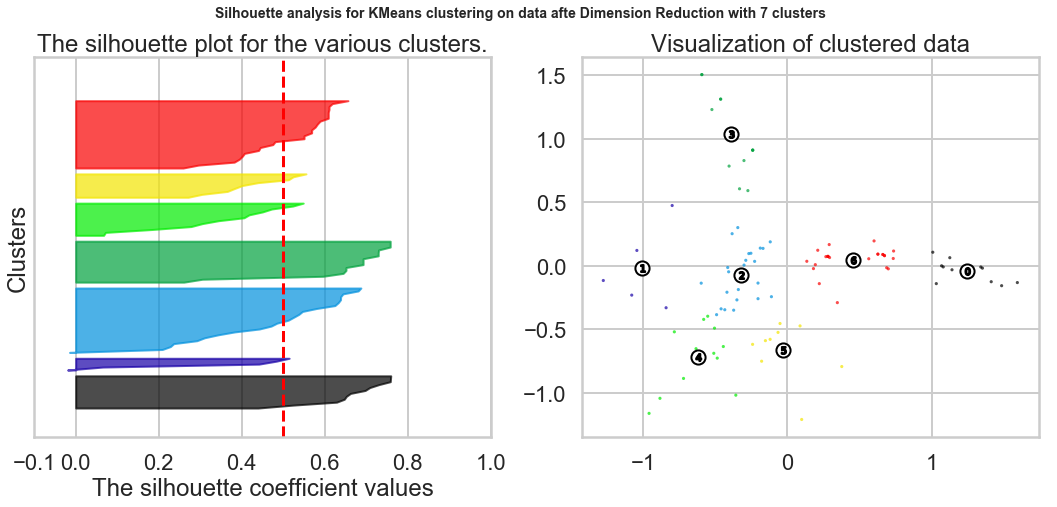

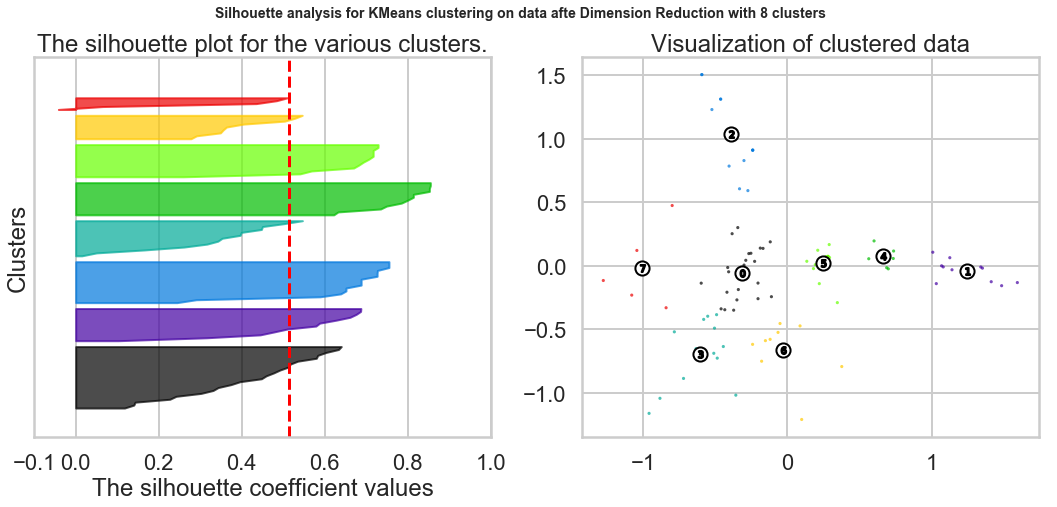

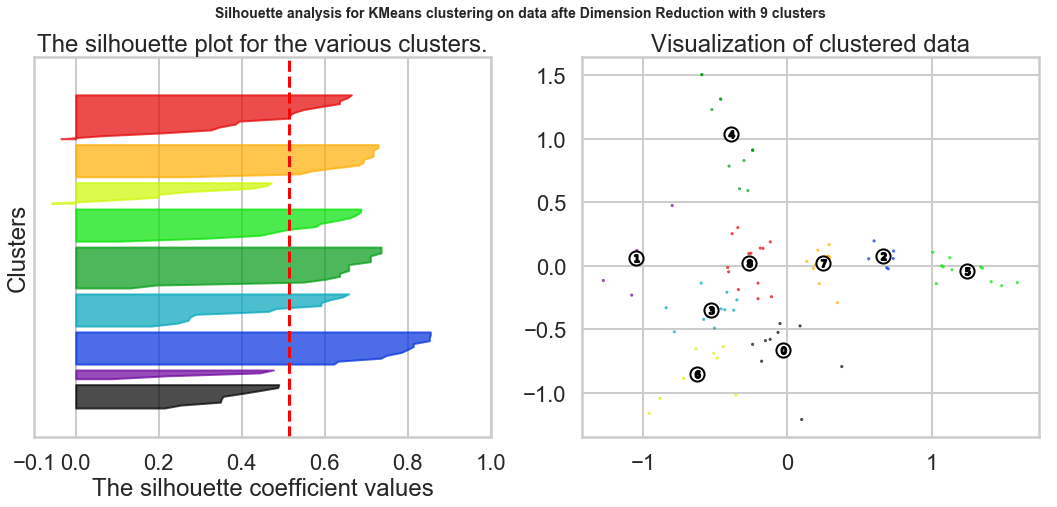

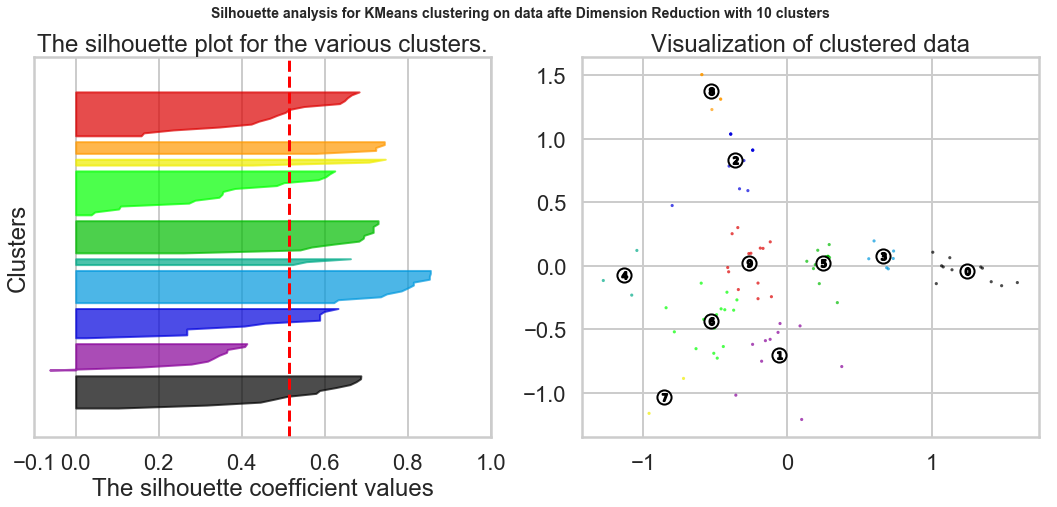

In [19]:


for k in ks:
    y_lower=10
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, 30+len(redu)])
    
    kmeans=KMeans(n_clusters=k)
    kfit=kmeans.fit_predict(redu)
    silhouette_avg= silhouette_score(redu, kfit)
    print('The silhouette score for {} clusters is: {}'.format(k,silhouette_avg))
    for i in range(k):
        
        ith_sam= silhouette_samples(redu, kfit)[kfit==i]
        ith_sam.sort()
        cluster_size= len(ith_sam)
       
        y_upper = y_lower + cluster_size
        color = cm.nipy_spectral(float(i) / k)
        #print(y_lower,y_upper, ith_sam)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0,ith_sam, facecolor=color,
                     edgecolor=color, alpha=0.7)
        #ax1.text(-0.5, (y_lower + (0.5 * cluster_size)), str(i))
        
        y_lower = y_upper+1
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Clusters")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(kfit.astype(float) / k)
    ax2.scatter(x, y, marker='.', s=40, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("Visualization of clustered data")
 

    plt.suptitle(("Silhouette analysis for KMeans clustering on data afte Dimension Reduction "
                  "with %d clusters" % k),
                 fontsize=14, fontweight='bold')
plt.show()

The silhouette scores confirm the findings of the elbow test. 3 clusters appears to be optimal despite the discrepancy in size between them.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

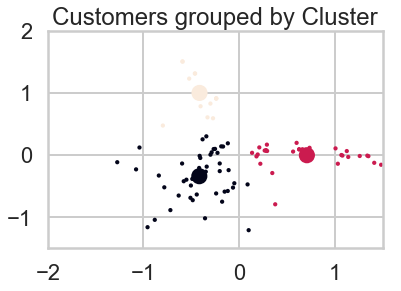

In [20]:
#your turn
#I did this for the last excercise so I will re-use that code
from sklearn.decomposition import PCA
pca= PCA(n_components=2)
redu=pca.fit_transform(x_cols)

x=redu[:,0]
y=redu[:,1]

kmeans=KMeans(n_clusters=3)
kfit=kmeans.fit_predict(redu)
df_cen=pd.DataFrame()
df_cen['x']=kmeans.cluster_centers_[:,0]
df_cen['y']=kmeans.cluster_centers_[:,1]
df_cen['cluster_id']=[0,1,2]
df_pca=pd.DataFrame()
df_pca['customer_name']= pd.Series(forCluster.index)

df_pca['x']=pd.Series(x)
df_pca['y']=pd.Series(y)
df_pca['cluster_id']=kfit
plt.scatter(df_pca.x, df_pca.y, c= df_pca.cluster_id, marker='.', s=20)
plt.scatter(df_cen.x, df_cen.y, c= df_cen.cluster_id, marker='o', s=200)
plt.xlim(-2, 1.5)
plt.ylim(-1.5, 2)
plt.title('Customers grouped by Cluster')
plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [21]:
df=pd.merge(df_pca, df_merged)

df.groupby('cluster_id').varietal.value_counts()

cluster_id  varietal          
0           Champagne             74
            Cabernet Sauvignon    30
            Prosecco              21
            Chardonnay            13
            Malbec                13
            Merlot                12
            Espumante              8
            Pinot Noir             7
            Pinot Grigio           1
1           Espumante             32
            Prosecco              20
            Malbec                18
            Pinot Grigio          16
            Merlot                 7
            Champagne              6
            Cabernet Sauvignon     2
            Chardonnay             1
2           Pinot Noir            37
            Prosecco               2
            Champagne              1
            Chardonnay             1
            Malbec                 1
            Merlot                 1
Name: varietal, dtype: int64

In [22]:
df.groupby('cluster_id').origin.value_counts()


cluster_id  origin      
0           France          84
            Chile           29
            Italy           12
            New Zealand     11
            Oregon          10
            Australia        9
            California       9
            Germany          8
            South Africa     7
1           France          37
            Australia       17
            South Africa    17
            Oregon          16
            Chile            8
            California       5
            Germany          1
            New Zealand      1
2           Australia       13
            Italy           12
            France           7
            Germany          7
            California       2
            New Zealand      1
            South Africa     1
Name: origin, dtype: int64

In [23]:
df.groupby('cluster_id').campaign.value_counts()


cluster_id  campaign 
0           August       28
            December     25
            February     20
            June         18
            March        17
            May          15
            October      15
            April        13
            January      13
            November      6
            July          5
            September     4
1           March        34
            December     18
            November     17
            July         14
            May           8
            April         3
            August        3
            February      2
            October       2
            June          1
2           October      13
            September    13
            January       7
            July          7
            April         1
            June          1
            May           1
Name: campaign, dtype: int64

In [24]:
df.groupby('cluster_id')[['min_qty', 'discount']].mean()

,min_qty,discount
cluster_id,,
0,80.379888,63.435754
1,16.823529,55.647059
2,65.581395,52.116279




The principal differentiater from the clustering is variety. Customers in cluster two bought champagne at a much higher rate than the other. Interestingly, customers from cluster one appeared to enjoy sparkling wines that were not champagne. This could be seen as them substituting a cheaper alternitive for champagne. Conversely, customers in cluster one appear to have no interest in sparkling wines or any wine besides Pinot Noir. With this in mind I beleive we should offer more champagne sales to customers from cluster one because they have an appetite for sparkling wine but are possibly concerned about the price. Cluster two is the largest cluster so results from it may be less actionable, but in addition to buying the most Champagne they also buy the most Cabernet Sauvignon so maybe if we offer more deals for that wine they will buy more. Cluster one should be offered more Pinot Noir deals because they do not appear to have much interest in anything else.

Customers also appear to be clustered based on the time of year they purchase. This could be a result of when they are most flush with cash. When planning who to offer deals to this information should be consulted based on the time of year.

Finally, I found it interesting the cluster with the lowest minimum quantity did not have the lowest discount. These accounts should be reviewed to ensure we are not losing too much money on these deals. It is possible cluster one is getting better deals because the other two, who appear to buy in bulk, are unwilling to buy such a small order.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

The explained variance from the default number of dimensions is: 0.0889835858586


Text(0,0.5,'Explained Variance')

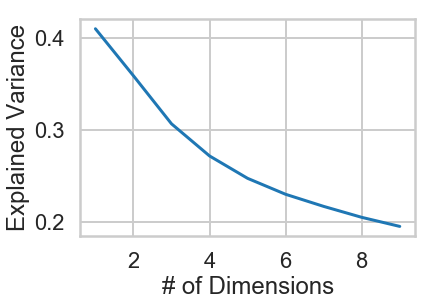

In [25]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()

pca.fit(x_cols)

print('The explained variance from the default number of dimensions is: {}'.format(np.mean(pca.explained_variance_)))
# Do the rest on your own :)
dimensions=range(1,10)
exp_var=[]
for d in dimensions:
    npca = sklearn.decomposition.PCA(n_components=d)
    npca.fit(x_cols)
    exp_var.append(np.mean(npca.explained_variance_))
plt.plot(dimensions, exp_var)
plt.xlabel('# of Dimensions')
plt.ylabel('Explained Variance')

The elbow point appears to be 3.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [93]:
# Your turn
from sklearn.cluster import AffinityPropagation



ap=AffinityPropagation()
apfit=ap.fit_predict(x_cols)
    

    
results['AP']=silhouette_score(x_cols,apfit)
silhouette_score(x_cols,apfit)
apfit

array([ 0, 10,  6,  3,  3, 12,  6,  7,  4,  2,  9, 13,  2, 12,  4,  6,  3,
        6,  0,  1,  2,  7,  4,  9,  6, 10, 11,  4, 12, 13,  3,  7,  4,  8,
        0,  5,  4,  2,  4,  5,  6,  6,  7, 12,  0,  8,  2,  3, 10, 13,  1,
       12, 13,  6,  7,  7,  6,  3,  0,  7, 12,  7, 12,  0,  0, 13,  6, 11,
        9, 10, 11, 10,  8,  3, 12,  3, 13,  3,  3, 13, 11, 10, 11, 13,  2,
        5,  0, 10, 10,  7, 12,  0,  7,  3,  1, 12,  7, 12,  8, 12])

In [85]:
from sklearn.cluster import SpectralClustering
respc=[]
for k in ks:
    sc=SpectralClustering(n_clusters=k)
    scfit=sc.fit_predict(x_cols)
    respc.append(silhouette_score(x_cols, scfit))
results['SC']=np.max(respc)
respc

[0.07631909829627558,
 0.10611539040197304,
 0.08627893400734331,
 0.09993402587297352,
 0.10474104219359186,
 0.07425567776798138,
 0.09724466468917155,
 0.0646739450074924,
 0.09554726266613597]

In [86]:
from sklearn.cluster import AgglomerativeClustering
resac=[]
for k in ks:
    ac=SpectralClustering(n_clusters=k)
    acfit=ac.fit_predict(x_cols)
    resac.append(silhouette_score(x_cols, acfit))
results['AC']=np.max(resac)
resac

[0.07631909829627558,
 0.10611539040197304,
 0.08627893400734331,
 0.09993402587297352,
 0.10566725999283566,
 0.07495906421470144,
 0.09713876052566305,
 0.0921820179560767,
 0.09179716529449118]

In [94]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
X=StandardScaler().fit_transform(redu)
db= DBSCAN()
dbfit= db.fit_predict(X)

results['DB']= silhouette_score(x_cols, dbfit)
dbfit

array([ 0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,
        1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  1, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0,  1,  0, -1,  0,  1,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

Text(0.5,1,'Silhouette Coefficient for different Clustering methods')

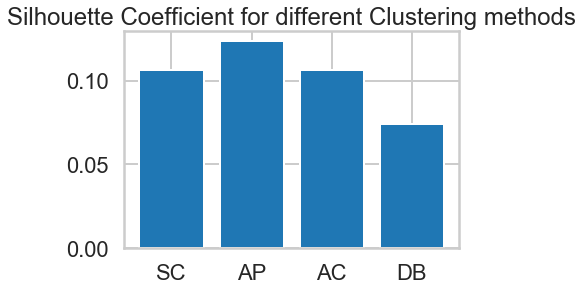

In [90]:
plt.bar(results.keys(), results.values())
plt.title('Silhouette Coefficient for different Clustering methods')

Affinity Propagation (AP) produces the best silhouette score. I found this interesting because it divided the data into 13 clusters. This does not match what we learned in previous exercises that appeared to show three was the optimal amount of clusters. Three was also the optimal number of clusters for Spectral and Agglomerative clustering so I do not think that number is off base. This is not surprising because AP typically uses many clusters and I believe because the high dimensionality of the data this algorithm was best suited. 